### Import packages

In [1]:
from statistics import mean
import numpy as np  
import matplotlib.pyplot as plt  
from vmdpy import VMD  
import pandas as pd
from vmd_post_func import *
import seaborn as sns
import pdb
from scipy.signal import find_peaks,peak_widths
from functools import reduce
import csv 
from vmd_optim import *

### Inputs

In [2]:
num_passes = 10
freq_res = 0.1
bin_width = 0.5
fs = 1000
num_peaks = 5
sensors = ['body','front_axle','rear_axle']
num_sensors = 3

### File inputs:

In [48]:
file_path = '../../parametric_study/case_studies/Rob_CNN/'
case_studies = ['short_span','med_span','long_span','small_thick','med_thick','large_thick','low_num','med_num'
                'high_num','low_num_constant_flexure','med_num_constant_flexure',
                'high_num_constant_flexure','thin_constant_mass',
                'med_thick_constant_mass','large_thick_constant_mass']
veh_class = 'SUV'

### Seaborn plotting style

In [49]:
# seaborn plot dictionary:
plot_style = {
    'font.size': 18.0,
    'font.family':'Times New Roman',
    'axes.labelsize': 16,
    'axes.titlesize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'axes.linewidth': 1.5,
    'axes.grid':True,
    'grid.linewidth': 0.8,
    'grid.linestyle':'--',
    'grid.color':'k',
    'lines.linewidth': 2,
    'lines.markersize': 8.0,
    'patch.linewidth': 1.0,
    'xtick.major.width': 0.8,
    'ytick.major.width': 0.8,
    'xtick.minor.width': 0.6,
    'ytick.minor.width': 0.6,
    'xtick.major.size': 5.5,
    'ytick.major.size': 5.5,
    'xtick.minor.size': 2.0,
    'ytick.minor.size': 2.0,
    'legend.title_fontsize': None
}

### Read VMD signals:

run number: 1
run number: 2
run number: 3
run number: 4
run number: 5
run number: 6
run number: 7
run number: 8
run number: 9
run number: 10


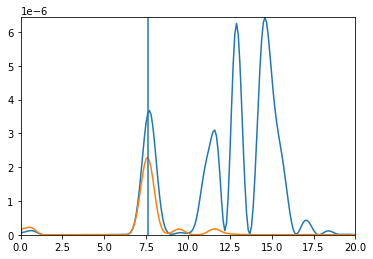

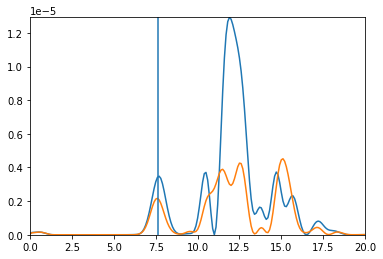

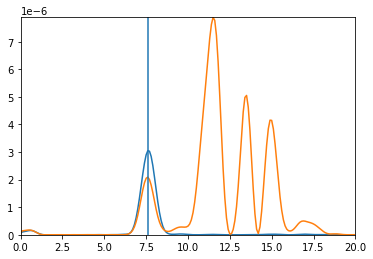

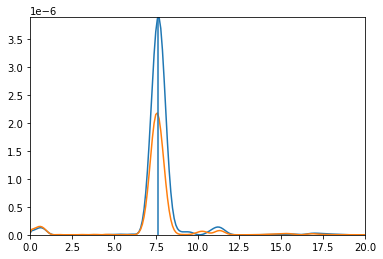

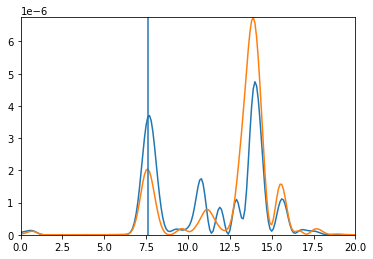

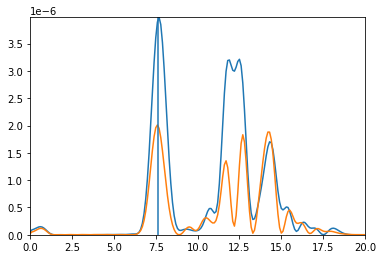

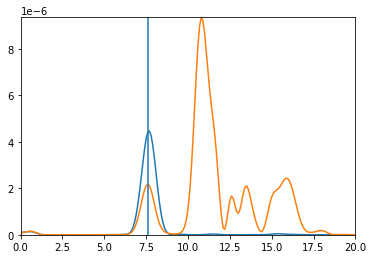

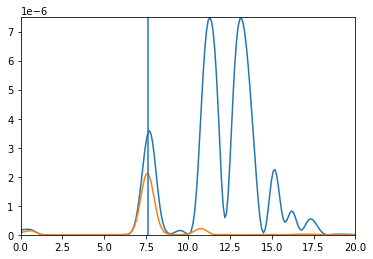

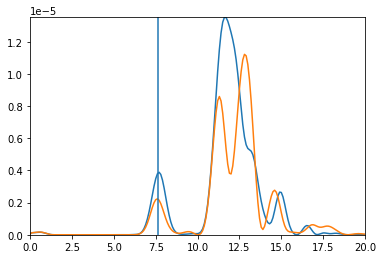

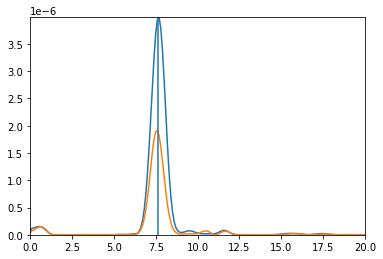

In [55]:
df_on_concat = pd.DataFrame()
df_off_concat = pd.DataFrame()
df_dom_veh_final = pd.DataFrame()
for pass_num in range(1,num_passes+1):
    
    with open("sample.txt", "a") as file_object:
        # Append 'hello' at the end of file
        file_object.write(f'run number: {pass_num}\n')
    
    print(f'run number: {pass_num}')
    # (1) csv file name for decomposed signals of off and on bridge data:
    csv_file_off = file_path+veh_class+'/'+case_studies[5]+'/vmd_sigs/dec_sigs_off_'+str(pass_num)+'.csv'
    csv_file_on = file_path+veh_class+'/'+case_studies[5]+'/vmd_sigs/dec_sigs_on_'+str(pass_num)+'.csv'
    
    # (2) read csv file into dataframe:
    df_vmd_sigs_off = pd.read_csv(csv_file_off)
    len_sig_off = len(df_vmd_sigs_off[(df_vmd_sigs_off['mode_num'] == 'mode_1') & (df_vmd_sigs_off['sensor'] == 'body')]['acc'].values)
    df_vmd_sigs_on = pd.read_csv(csv_file_on)
    len_sig_on = len(df_vmd_sigs_on[(df_vmd_sigs_on['mode_num'] == 'mode_1') & (df_vmd_sigs_on['sensor'] == 'body')]['acc'].values)
    
    # (3) Select first mode:
    # off-bridge:
    sel_dec_off = np.zeros((len_sig_off,num_sensors))
    sel_dec_on= np.zeros((len_sig_on,num_sensors))
    for count,sens in enumerate(sensors):
        sel_dec_off[:,count] = df_vmd_sigs_off[(df_vmd_sigs_off['sensor']==sens) & (df_vmd_sigs_off['mode_num']=='mode_1')]['acc'].values
        sel_dec_on[:,count] = df_vmd_sigs_on[(df_vmd_sigs_on['sensor']==sens) & (df_vmd_sigs_on['mode_num']=='mode_1')]['acc'].values
    
    # (4) Compute psd:
    # preallocate lists to store psd matrices of decomposed signals:
    f,sel_psd_off = get_psd_welch(sel_dec_off,freq_res,fs)
    max_psd_off = np.max(sel_psd_off,axis=0)
    idx_max_psd_off = np.argmax(sel_psd_off,axis=0)
    df_dom_veh = pd.DataFrame({'peak_f': f[idx_max_psd_off],'peak_psd':max_psd_off})
    
    # (5) Compute peak widths:
    p_widths = [peak_widths(sel_psd_off[:,count].T, [idx], rel_height=0.5) for count, idx in enumerate(idx_max_psd_off)]
    f_low = [1 if int(np.floor(p_widths[i][-2])) == 0 else int(np.floor(p_widths[i][-2])) for i in range(num_sensors)] # lower frequency
    f_up = [int(np.ceil(p_widths[i][-1])) for i in range(num_sensors)] # upper frequency
    f_bounds = [f[f_low],f[f_up]]
    
    # (6) Execute bandstop filter:
    # off-bridge:
    sig_final_off = np.zeros(sel_dec_off.shape)
    for i in range(num_sensors):
        sig_final_off[:,i] = butter_filter(sel_dec_off[:,i], [f_bounds[0][i],f_bounds[1][i]], 'bandstop', fs, 8)
    # on-bridge:
    sig_final_on = np.zeros(sel_dec_on.shape)
    for i in range(num_sensors):
        sig_final_on[:,i] = butter_filter(sel_dec_on[:,i], [f_bounds[0][i],f_bounds[1][i]], 'bandstop', fs, 8)

    # (7) Compute psd:
    # Off-bridge:
    f,psd_final_off = get_psd_welch(sig_final_off,freq_res,fs)
    # On-bridge:
    f,psd_final_on = get_psd_welch(sig_final_on,freq_res,fs)
    fig,axs = plt.subplots(1)
    axs.plot(f,psd_final_on[:,1])
    axs.plot(f,psd_final_on[:,2])
    axs.vlines(7.64,0,1)
    axs.set_xlim([0,20])
    axs.set_ylim([0,np.max(psd_final_on[:,1:])])
    
    # (12) Peak picking:
    # off-bridge:
    peak_psd_off,peak_f_off = get_peaks(f,psd_final_off,num_peaks)
    # on-bridge:
    peak_psd_on,peak_f_on = get_peaks(f,psd_final_on,num_peaks)
    # (13) Store final results into dataframes:
    # off-bridge:
    res_dict = {'peak_f':[],'peak_psd':[],'sensor':[],'pass_num':[]}
    for idx_out,p_psd in enumerate(peak_psd_off):
        for idx_in,elem in enumerate(p_psd):
            res_dict['peak_f'].append(peak_f_off[idx_out][idx_in])
            res_dict['peak_psd'].append(elem)
            res_dict['sensor'].append(sensors[idx_out])
            res_dict['pass_num'].append(pass_num)
    df_off = pd.DataFrame(res_dict)
    # on-bridge:
    res_dict = {'peak_f':[],'peak_psd':[],'sensor':[],'pass_num':[]}
    for idx_out,p_psd in enumerate(peak_psd_on):
        for idx_in,elem in enumerate(p_psd):
            res_dict['peak_f'].append(peak_f_on[idx_out][idx_in])
            res_dict['peak_psd'].append(elem)
            res_dict['sensor'].append(sensors[idx_out])
            res_dict['pass_num'].append(pass_num)
    df_on = pd.DataFrame(res_dict)

    # (14) Concatenate dfs into one final df:
    # off-bridge:
    df_off_concat = pd.concat((df_off_concat,df_off))
    # on-bridge:
    df_on_concat = pd.concat((df_on_concat,df_on))
    # dominant vehicle frequencies:
    df_dom_veh_final = pd.concat((df_dom_veh_final,df_dom_veh))
# reset indices:
df_off_concat.reset_index(inplace=True,drop=True)
df_on_concat.reset_index(inplace=True,drop=True)


array([0.000e+00, 1.000e-01, 2.000e-01, ..., 4.998e+02, 4.999e+02,
       5.000e+02])

In [6]:
p_widths = [peak_widths(sel_psd_off[:,count].T, [idx], rel_height=0.5) for count, idx in enumerate(idx_max_psd_off)]
f_low = [1 if int(np.floor(p_widths[i][-2])) == 0 else int(np.floor(p_widths[i][-2])) for i in range(num_sensors)] # lower frequency
f_up = [int(np.ceil(p_widths[i][-1])) for i in range(num_sensors)] # upper frequency
f_bounds = [f[f_low],f[f_up]]
p_widths[0]

(array([5.84374609]),
 array([2.11459719e-08]),
 array([103.11087534]),
 array([108.95462144]))

### First 5 elements of grouped off-bridge signals:

In [7]:
df_off_concat.head()

,peak_f,peak_psd,sensor,pass_num
0,10.0,3.586790e-08,body,1
1,10.1,3.520712e-08,body,1
2,11.1,2.496946e-08,body,1
3,11.2,2.400907e-08,body,1
4,9.9,2.326822e-08,body,1


In [8]:
df_on_concat.head()

,peak_f,peak_psd,sensor,pass_num
0,0.6,0.000005,body,1
1,0.7,0.000005,body,1
2,0.5,0.000005,body,1
3,0.6,0.000002,front_axle,1
4,0.5,0.000002,front_axle,1


### Drop frequencies that are repeated less than 20% of the time:

In [9]:
df_on_concat = drop_rep_freq(df_on_concat,2).reset_index(drop=True)
df_off_concat = drop_rep_freq(df_off_concat,2)
df_dom_veh_final = drop_rep_freq(df_dom_veh_final,2)

### Separate dfs into respective sensors on-bridge:

In [10]:
df_body_on = df_on_concat[df_on_concat['sensor'] == 'body'].copy().reset_index(drop=True).drop('sensor',axis=1)
df_front_on = df_on_concat[df_on_concat['sensor'] == 'front_axle'].copy().reset_index(drop=True).drop('sensor',axis=1)
df_rear_on = df_on_concat[df_on_concat['sensor'] == 'rear_axle'].copy().reset_index(drop=True).drop('sensor',axis=1)

In [11]:
df_front_on

,peak_f,peak_psd,pass_num
0,0.6,2.444414e-06,1
1,0.5,2.393493e-06,1
2,0.7,2.330689e-06,1
3,5.7,2.502350e-07,1
4,5.8,2.496364e-07,1
5,0.6,2.467161e-06,2
6,0.5,2.410904e-06,2
7,0.7,2.356672e-06,2
8,5.7,2.615845e-07,2
9,5.8,2.585388e-07,2


In [12]:
df_rear_on

,peak_f,peak_psd,pass_num
0,0.6,0.000003,1
1,0.7,0.000002,1
2,0.5,0.000002,1
3,0.6,0.000002,2
4,0.7,0.000002,2
5,0.5,0.000002,2
6,0.6,0.000003,3
7,0.7,0.000003,3
8,0.5,0.000003,3
9,0.6,0.000003,4


### Separate dfs into respective sensors off-bridge:

In [13]:
df_body_off = df_off_concat[df_off_concat['sensor'] == 'body'].copy().reset_index(drop=True).drop('sensor',axis=1)
df_front_off = df_off_concat[df_off_concat['sensor'] == 'front_axle'].copy().reset_index(drop=True).drop('sensor',axis=1)
df_rear_off = df_off_concat[df_off_concat['sensor'] == 'rear_axle'].copy().reset_index(drop=True).drop('sensor',axis=1)

In [14]:
df_front_off

,peak_f,peak_psd,pass_num
0,10.3,1.725255e-06,1
1,10.4,1.706547e-06,1
2,10.8,9.868348e-07,1
3,10.7,7.048208e-07,1
4,11.0,1.539829e-06,2
5,10.9,1.518309e-06,2
6,11.1,1.508967e-06,2
7,11.6,5.134393e-07,2
8,11.2,7.968825e-07,3
9,11.1,5.543646e-07,3


In [15]:
df_rear_off

,peak_f,peak_psd,pass_num
0,10.4,1.204263e-06,1
1,10.3,1.107701e-06,1
2,10.8,9.567510e-07,1
3,10.9,5.842574e-07,1
4,11.2,5.522356e-07,1
5,11.1,1.180945e-06,2
6,11.0,1.131727e-06,2
7,11.2,9.688057e-07,2
8,11.6,3.869404e-07,2
9,10.8,1.024611e-06,3


### Bin data for on-birdge:

In [16]:
# Body:
df_body_on_bin = bin_df(df_body_on,bin_width)
# Front:
df_front_on_bin = bin_df(df_front_on,bin_width)
# Rear: 
df_rear_on_bin = bin_df(df_rear_on,bin_width)

In [17]:
df_front_on_bin

,peak_f,peak_psd,pass_num,bins
0,0.6,2.444414e-06,1,"[0.5, 1.0)"
1,0.5,2.393493e-06,1,"[0.5, 1.0)"
2,0.7,2.330689e-06,1,"[0.5, 1.0)"
3,5.7,2.502350e-07,1,"[5.5, 6.0)"
4,5.8,2.496364e-07,1,"[5.5, 6.0)"
5,0.6,2.467161e-06,2,"[0.5, 1.0)"
6,0.5,2.410904e-06,2,"[0.5, 1.0)"
7,0.7,2.356672e-06,2,"[0.5, 1.0)"
8,5.7,2.615845e-07,2,"[5.5, 6.0)"
9,5.8,2.585388e-07,2,"[5.5, 6.0)"


In [18]:
df_rear_on_bin

,peak_f,peak_psd,pass_num,bins
0,0.6,0.000003,1,"[0.5, 1.0)"
1,0.7,0.000002,1,"[0.5, 1.0)"
2,0.5,0.000002,1,"[0.5, 1.0)"
3,0.6,0.000002,2,"[0.5, 1.0)"
4,0.7,0.000002,2,"[0.5, 1.0)"
5,0.5,0.000002,2,"[0.5, 1.0)"
6,0.6,0.000003,3,"[0.5, 1.0)"
7,0.7,0.000003,3,"[0.5, 1.0)"
8,0.5,0.000003,3,"[0.5, 1.0)"
9,0.6,0.000003,4,"[0.5, 1.0)"


### Finding common frequencies between front and rear axles:

#### Test part of the find_common function

In [19]:
elem_intersect = np.unique(df_front_on_bin[df_front_on_bin['bins'].isin(df_rear_on_bin['bins'])]['bins'].to_numpy())
elem_intersect

array([Interval(0.5, 1.0, closed='left')], dtype=object)

In [20]:
# concatenate and extract the elements that are within the intersection:
df_concat = pd.concat((df_front_on_bin,df_rear_on_bin))
df_concat = df_concat.loc[df_concat['bins'].isin(elem_intersect)].reset_index(drop=True)
df_concat

,peak_f,peak_psd,pass_num,bins
0,0.6,0.000002,1,"[0.5, 1.0)"
1,0.5,0.000002,1,"[0.5, 1.0)"
2,0.7,0.000002,1,"[0.5, 1.0)"
3,0.6,0.000002,2,"[0.5, 1.0)"
4,0.5,0.000002,2,"[0.5, 1.0)"
5,0.7,0.000002,2,"[0.5, 1.0)"
6,0.6,0.000003,3,"[0.5, 1.0)"
7,0.5,0.000003,3,"[0.5, 1.0)"
8,0.7,0.000003,3,"[0.5, 1.0)"
9,0.6,0.000003,4,"[0.5, 1.0)"


In [21]:
# group by bins and vehicle pass to distinguish between them:
df_group = df_concat.groupby(['bins','pass_num']).agg(peak_f=('peak_f',lambda x: x.iloc[0]),count=('bins','count'),
                                                    mean_peak_psd=('peak_psd','mean')).dropna().reset_index()
df_group

,bins,pass_num,peak_f,count,mean_peak_psd
0,"[0.5, 1.0)",1,0.6,6,0.000002
1,"[0.5, 1.0)",2,0.6,6,0.000002
2,"[0.5, 1.0)",3,0.6,6,0.000003
3,"[0.5, 1.0)",4,0.6,6,0.000003
4,"[0.5, 1.0)",5,0.6,6,0.000002
5,"[0.5, 1.0)",6,0.6,6,0.000002
6,"[0.5, 1.0)",7,0.5,5,0.000003
7,"[0.5, 1.0)",8,0.6,6,0.000003
8,"[0.5, 1.0)",9,0.6,6,0.000002
9,"[0.5, 1.0)",10,0.5,5,0.000003


In [22]:
df_group.groupby('peak_f').agg(bins=('bins',lambda x: x.iloc[0]),count=('peak_f','count'),mean_peak_psd=('mean_peak_psd','mean')).dropna().reset_index()


,peak_f,bins,count,mean_peak_psd
0,0.5,"[0.5, 1.0)",2,0.000003
1,0.6,"[0.5, 1.0)",8,0.000003


#### beginning of find_common function:

In [23]:
df_on_common = find_common(df_front_on_bin,df_rear_on_bin)
df_on_common

,peak_f,bins,count,mean_peak_psd
0,0.5,"[0.5, 1.0)",2,0.000003
1,0.6,"[0.5, 1.0)",8,0.000003


In [24]:
df_freq_on = df_on_common.drop('bins',axis=1)
df_freq_on

,peak_f,count,mean_peak_psd
0,0.5,2,0.000003
1,0.6,8,0.000003


In [25]:
df_bins_on = df_on_common.groupby('bins').agg(counts=('count','sum'),mean_peak_psd=('mean_peak_psd','mean')).dropna().reset_index()
df_bins_on

,bins,counts,mean_peak_psd
0,"[0.5, 1.0)",10,0.000003


### Bin data for off-birdge:

In [26]:
# Body:
df_body_off_bin = bin_df(df_body_off,bin_width)
# Front:
df_front_off_bin = bin_df(df_front_off,bin_width)
# Rear: 
df_rear_off_bin = bin_df(df_rear_off,bin_width)

In [27]:
df_front_off_bin

,peak_f,peak_psd,pass_num,bins
0,10.3,1.725255e-06,1,"[10.0, 10.5)"
1,10.4,1.706547e-06,1,"[10.0, 10.5)"
2,10.8,9.868348e-07,1,"[10.5, 11.0)"
3,10.7,7.048208e-07,1,"[10.5, 11.0)"
4,11.0,1.539829e-06,2,"[11.0, 11.5)"
5,10.9,1.518309e-06,2,"[10.5, 11.0)"
6,11.1,1.508967e-06,2,"[11.0, 11.5)"
7,11.6,5.134393e-07,2,"[11.5, 12.0)"
8,11.2,7.968825e-07,3,"[11.0, 11.5)"
9,11.1,5.543646e-07,3,"[11.0, 11.5)"


In [28]:
df_rear_off_bin

,peak_f,peak_psd,pass_num,bins
0,10.4,1.204263e-06,1,"[10.0, 10.5)"
1,10.3,1.107701e-06,1,"[10.0, 10.5)"
2,10.8,9.567510e-07,1,"[10.5, 11.0)"
3,10.9,5.842574e-07,1,"[10.5, 11.0)"
4,11.2,5.522356e-07,1,"[11.0, 11.5)"
5,11.1,1.180945e-06,2,"[11.0, 11.5)"
6,11.0,1.131727e-06,2,"[11.0, 11.5)"
7,11.2,9.688057e-07,2,"[11.0, 11.5)"
8,11.6,3.869404e-07,2,"[11.5, 12.0)"
9,10.8,1.024611e-06,3,"[10.5, 11.0)"


### Finding common frequencies between front and rear axles:

In [29]:
df_off_common = find_common(df_front_off_bin,df_rear_off_bin)
df_off_common

,peak_f,bins,count,mean_peak_psd
0,10.3,"[10.0, 10.5)",1,1.435942e-06
1,10.4,"[10.0, 10.5)",4,2.022824e-06
2,10.5,"[10.5, 11.0)",1,1.804658e-06
3,10.6,"[10.5, 11.0)",1,1.937600e-06
4,10.7,"[10.5, 11.0)",2,2.005623e-06
5,10.8,"[10.5, 11.0)",4,1.376509e-06
6,10.9,"[10.5, 11.0)",1,1.518309e-06
7,11.0,"[11.0, 11.5)",1,1.266055e-06
8,11.2,"[11.0, 11.5)",4,9.175513e-07
9,11.3,"[11.0, 11.5)",3,8.042932e-07


In [30]:
df_freq_off = df_off_common.drop('bins',axis=1)
df_freq_off

,peak_f,count,mean_peak_psd
0,10.3,1,1.435942e-06
1,10.4,4,2.022824e-06
2,10.5,1,1.804658e-06
3,10.6,1,1.937600e-06
4,10.7,2,2.005623e-06
5,10.8,4,1.376509e-06
6,10.9,1,1.518309e-06
7,11.0,1,1.266055e-06
8,11.2,4,9.175513e-07
9,11.3,3,8.042932e-07


In [31]:
df_bins_off = df_off_common.groupby('bins').agg(counts=('count','sum'),mean_peak_psd=('mean_peak_psd','mean')).dropna().reset_index()
df_bins_off

,bins,counts,mean_peak_psd
0,"[10.0, 10.5)",5,1.729383e-06
1,"[10.5, 11.0)",9,1.728540e-06
2,"[11.0, 11.5)",8,9.959664e-07
3,"[11.5, 12.0)",2,4.332228e-07


### get set difference between on and off bridge data

In [32]:
df_diff = get_diff_col(df_bins_on,df_bins_off,'bins')

In [33]:
df_diff

,bins,counts,mean_peak_psd
0,"[0.5, 1.0)",10.0,0.000003


### Extract exact frequencies from the binned data

In [34]:
df_freq_final = df_on_common[df_on_common['bins'].isin(df_diff['bins'])].reset_index(drop=True)
df_freq_final

,peak_f,bins,count,mean_peak_psd
0,0.5,"[0.5, 1.0)",2,0.000003
1,0.6,"[0.5, 1.0)",8,0.000003


### Compute statistics

In [35]:
# probability of detecting bridge freq
df_stat = df_freq_final.copy()
df_stat['prob'] = df_freq_final['count']/10
# compute bridge to vehicle mean psd ratio:
df_stat['mean_ratio'] = df_freq_final['mean_peak_psd']/df_bins_off['mean_peak_psd'].max()
# add column to distinguish between analyses:
df_stat['veh_class'] = df_stat.shape[0]*[veh_class]
df_stat['case'] = df_stat.shape[0]*[case_studies[4]]
df_stat

,peak_f,bins,count,mean_peak_psd,prob,mean_ratio,veh_class,case
0,0.5,"[0.5, 1.0)",2,0.000003,0.2,1.538719,SUV,med_thick
1,0.6,"[0.5, 1.0)",8,0.000003,0.8,1.452054,SUV,med_thick


### Plot histograms

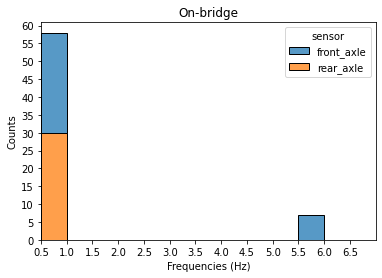

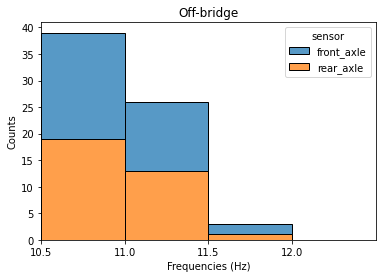

In [36]:
fig_on,hist_on = get_hist_freq(df_on_concat,['front_axle','rear_axle'],bin_width,'On-bridge')
fig_off,hist_off = get_hist_freq(df_off_concat,['front_axle','rear_axle'],bin_width,'Off-bridge')